In [131]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from prophet import Prophet


import warnings
warnings.filterwarnings('ignore')

In [132]:
# Loading data
data = pd.read_csv('Wide-World-Importers-Time-Series-prophet.csv')

In [133]:
# Checking data types and info
data.info()
data.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Order Date   1069 non-null   int64
 1   Total Sales  1069 non-null   int64
dtypes: int64(2)
memory usage: 16.8 KB


Order Date     int64
Total Sales    int64
dtype: object

In [134]:
data

,Order Date,Total Sales
0,20150101,185750
1,20150102,153874
2,20150103,197511
3,20150104,148053
4,20150105,129639
...,...,...
1064,20180526,342440
1065,20180527,285897
1066,20180528,122899
1067,20180530,213954


In [135]:
df = data

In [136]:
df['Year'] = df['Order Date'].apply(lambda x: str(x)[-8:-4])
df['Month'] = df['Order Date'].apply(lambda x: str(x)[-4:-2])
df['Day'] = df['Order Date'].apply(lambda x: str(x)[-2:])
df['ds'] = pd.DatetimeIndex(df['Year'] +'-'+df['Month']+'-'+df['Day'])

In [137]:
df.head(2)

,Order Date,Total Sales,Year,Month,Day,ds
0,20150101,185750,2015,01,01,2015-01-01
1,20150102,153874,2015,01,02,2015-01-02


In [138]:
# Drop columns that are not needed inc. unique values, axis=1 is to drop the coloumns 
# inplace=True is for the same dataset (not creating another dataset)

df.drop(['Order Date', 'Year', 'Month', 'Day'], axis=1, inplace=True)
df.columns = 'y', 'ds'

In [139]:
df.head(2)

,y,ds
0,185750,2015-01-01
1,153874,2015-01-02


In [140]:
# Pre-processing
df['ds']=pd.to_datetime(df['ds'], format='%Y-%m-%d')
df.set_index(['ds'], inplace=True)


In [141]:
data.dtypes

y    int64
dtype: object

In [142]:
# Filling in nulls
df.fillna(method='pad', inplace=True)


In [143]:
# Resampling to fill in missing dates, M is turning it into months.
df = df.resample("M").sum()

In [144]:
df.head(10)

,y
ds,
2015-01-31,5712967
2015-02-28,4179110
2015-03-31,5876868
2015-04-30,6154185
2015-05-31,6709101
2015-06-30,6136984
2015-07-31,6648934
2015-08-31,5268538
2015-09-30,5725387


In [145]:
df = df.groupby('ds')['y'].sum()
# Print the output.
md = df.reset_index()
print(md)


           ds        y
0  2015-01-31  5712967
1  2015-02-28  4179110
2  2015-03-31  5876868
3  2015-04-30  6154185
4  2015-05-31  6709101
5  2015-06-30  6136984
6  2015-07-31  6648934
7  2015-08-31  5268538
8  2015-09-30  5725387
9  2015-10-31  5675744
10 2015-11-30  5591657
11 2015-12-31  5467396
12 2016-01-31  6138144
13 2016-02-29  5229061
14 2016-03-31  5792559
15 2016-04-30  6141586
16 2016-05-31  6909163
17 2016-06-30  6399739
18 2016-07-31  7210185
19 2016-08-31  6142918
20 2016-09-30  5817312
21 2016-10-31  6677888
22 2016-11-30  6045603
23 2016-12-31  6536223
24 2017-01-31  6617169
25 2017-02-28  6294784
26 2017-03-31  6769654
27 2017-04-30  7608887
28 2017-05-31  6713191
29 2017-06-30  6765247
30 2017-07-31  7699630
31 2017-08-31  5899025
32 2017-09-30  6968552
33 2017-10-31  6680094
34 2017-11-30  6061147
35 2017-12-31  6626268
36 2018-01-31  6606015
37 2018-02-28  5904877
38 2018-03-31  6873249
39 2018-04-30  6767988
40 2018-05-31  7349006


Prophet Model

In [146]:
m = Prophet(interval_width=0.95)

model = m.fit(md)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [147]:
#Forecast - trends, lower and upper estimates, daily seasonality, yhat is the predicted forecast
#periods you want to forecast for - up to 100. Frequency is by Month
# second line forecasts forward

future = m.make_future_dataframe(periods=20,freq='M')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-31,5.576017e+06,5.167606e+06,6.094017e+06,5.576017e+06,5.576017e+06,6.075449e+04,6.075449e+04,6.075449e+04,6.075449e+04,6.075449e+04,6.075449e+04,0.0,0.0,0.0,5.636771e+06
1,2015-02-28,5.615123e+06,4.000529e+06,4.909661e+06,5.615123e+06,5.615123e+06,-1.193702e+06,-1.193702e+06,-1.193702e+06,-1.193702e+06,-1.193702e+06,-1.193702e+06,0.0,0.0,0.0,4.421421e+06
2,2015-03-31,5.658420e+06,5.402029e+06,6.352489e+06,5.658420e+06,5.658420e+06,2.090186e+05,2.090186e+05,2.090186e+05,2.090186e+05,2.090186e+05,2.090186e+05,0.0,0.0,0.0,5.867438e+06
3,2015-04-30,5.700320e+06,5.523182e+06,6.467346e+06,5.700320e+06,5.700320e+06,2.938495e+05,2.938495e+05,2.938495e+05,2.938495e+05,2.938495e+05,2.938495e+05,0.0,0.0,0.0,5.994169e+06
4,2015-05-31,5.743616e+06,5.941142e+06,6.849191e+06,5.743616e+06,5.743616e+06,6.255961e+05,6.255961e+05,6.255961e+05,6.255961e+05,6.255961e+05,6.255961e+05,0.0,0.0,0.0,6.369212e+06


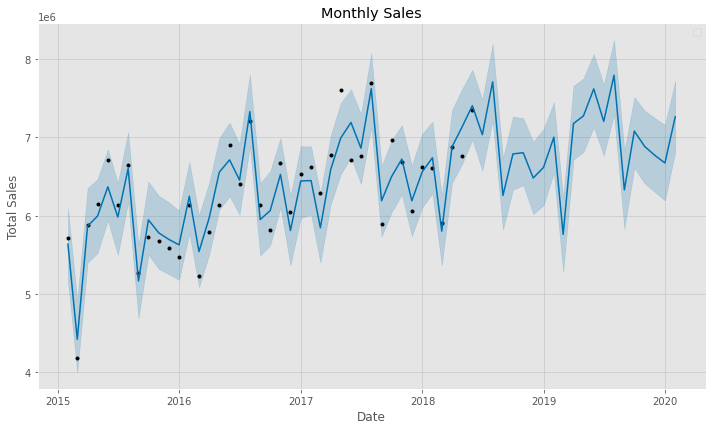

In [153]:
#Plot data, prophet model is stored in variable m


plot1 = m.plot(forecast)
plt.title('Monthly Sales')
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.legend()
plt.show()

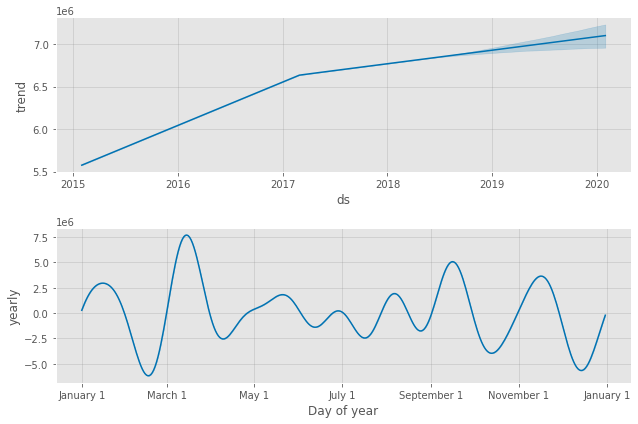

In [149]:
#Decompose (B)

plot2 = m.plot_components(forecast)

In [150]:
#Ceate a metric dataframe that essentially joins the actual values from monthly_inc (y)
#with the predicted values from the forecast table
#using the common key 'ds'
metric_df = forecast.set_index('ds')[['yhat']].join(md.set_index('ds').y).reset_index()
metric_df

,ds,yhat,y
0,2015-01-31,5.636771e+06,5712967.0
1,2015-02-28,4.421421e+06,4179110.0
2,2015-03-31,5.867438e+06,5876868.0
3,2015-04-30,5.994169e+06,6154185.0
4,2015-05-31,6.369212e+06,6709101.0
...,...,...,...
56,2019-09-30,7.080906e+06,NaN
57,2019-10-31,6.885207e+06,NaN
58,2019-11-30,6.773601e+06,NaN
59,2019-12-31,6.673567e+06,NaN


In [151]:
#let's drop those predicted values and focus on how well the model has fit with historical data
metric_df.dropna(inplace=True)

In [152]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_prophet = sqrt(mean_squared_error(metric_df.y, metric_df.yhat))
print(rmse_prophet)

235621.34819937267
